In [2]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, auc, RocCurveDisplay
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

seed = 42
tf.random.set_seed(seed)

%matplotlib inline

In [3]:
data_path = './raw-data/'
data_folders = os.listdir(data_path)

# Load both types of loans to investigate.
accepted_path = data_path + data_folders[0]
rejected_path = data_path + data_folders[1]
print(accepted_path, rejected_path)

accepted_df= pd.read_csv(accepted_path)
print('Finished reading accepted csv.')

rejected_df = pd.read_csv(rejected_path)
print('Finished reading rejected csv.')

./raw-data/accepted_2007_to_2018Q4.csv ./raw-data/rejected_2007_to_2018Q4.csv


/tmp/ipykernel_213917/351568420.py:9: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df= pd.read_csv(accepted_path)


Finished reading accepted csv.
Finished reading rejected csv.


In [4]:
# Initial data exploration

print(accepted_df.shape)
print(rejected_df.shape)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Judging by the columns of rejected loans, rejected data is going to be useless for our purposes.
print(accepted_df.head(2).T)
print(rejected_df.head(2).T)

(2260701, 151)
(27648741, 9)
                                                                                            0   
id                                                                                   68407277  \
member_id                                                                                 NaN   
loan_amnt                                                                              3600.0   
funded_amnt                                                                            3600.0   
funded_amnt_inv                                                                        3600.0   
term                                                                                36 months   
int_rate                                                                                13.99   
installment                                                                            123.03   
grade                                                                                       C   
s

In [5]:
# Analyze the types of variables and their statistics.
accepted_df.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,2260701.0,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,2093699,2113761,2260668,2.260664e+06,2260668,2260668,2260668,2260668,2260668,126065,2260668,2237342,2260667,2260668,2.258957e+06,2.260639e+06,2260639,2.260668e+06,2.260668e+06,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2260668,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2258241,2.260668e+06,915358,2260596,2.260668e+06,2.260668e+06,2.260523e+06,580775.000000,2260668.0,2260668,1.207100e+05,120706.000000,115730,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021.000000,108021.000000,108021,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,2260668,10917,10917,10917,10917

In [6]:
# The dataset seems to contain many missing values. Lets try to quantify how many per column.
nan_per_column = accepted_df.isna().sum()
nan_per_column

id                                                  0
member_id                                     2260701
loan_amnt                                          33
funded_amnt                                        33
funded_amnt_inv                                    33
term                                               33
int_rate                                           33
installment                                        33
grade                                              33
sub_grade                                          33
emp_title                                      167002
emp_length                                     146940
home_ownership                                     33
annual_inc                                         37
verification_status                                33
issue_d                                            33
loan_status                                        33
pymnt_plan                                         33
url                         

In [7]:
# To make it more readable, lets interpret them via percentage.
nan_percent_per_column = (nan_per_column / accepted_df.shape[0]) * 100
nan_percent_per_column


id                                              0.000000
member_id                                     100.000000
loan_amnt                                       0.001460
funded_amnt                                     0.001460
funded_amnt_inv                                 0.001460
term                                            0.001460
int_rate                                        0.001460
installment                                     0.001460
grade                                           0.001460
sub_grade                                       0.001460
emp_title                                       7.387178
emp_length                                      6.499754
home_ownership                                  0.001460
annual_inc                                      0.001637
verification_status                             0.001460
issue_d                                         0.001460
loan_status                                     0.001460
pymnt_plan                     

In [8]:
# Exploring columns with more than 15% missing values to see which can be dropped.
usable_columns = accepted_df.columns[(nan_percent_per_column < 15)].to_list()
print("Number of culumns before:",len(accepted_df.columns))
print("Number of culumns after",len(usable_columns))
usable_df = accepted_df[usable_columns]
usable_df.info()

Number of culumns before: 151
Number of culumns after 93
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 93 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id                          object 
 1   loan_amnt                   float64
 2   funded_amnt                 float64
 3   funded_amnt_inv             float64
 4   term                        object 
 5   int_rate                    float64
 6   installment                 float64
 7   grade                       object 
 8   sub_grade                   object 
 9   emp_title                   object 
 10  emp_length                  object 
 11  home_ownership              object 
 12  annual_inc                  float64
 13  verification_status         object 
 14  issue_d                     object 
 15  loan_status                 object 
 16  pymnt_plan                  object 
 17  url                         object 
 18  purpo

<Axes: xlabel='loan_status'>

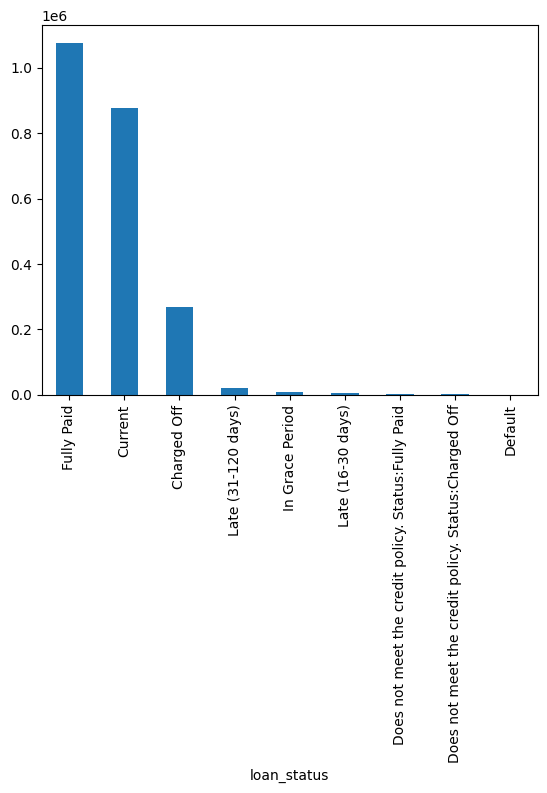

In [7]:
"""
The dataset contains way too many features.
Since our goal is to create an e2e system for predicting loan defaults (in limited time), we need to pick
such features, that the users would not have any issues providing. Furthermore, there shouldn't be too many
of them, so that the users will only spend a reasonable amount of time providing them.

If we were to build a commercial system, we could, for example, create a pipeline or specific forms
via which we could gather a greater amount of data to create features from.

In order to gain better insight into which features could be most useful and easiest for the users to provide,
we researched the discussions linked to the provided dataset, where these features were explained.
"""
# Our target labels are present in the loan_status column.
# Here, we are only interested in the Fully Paid and Charged Off (default) loans.
# There are more potentially useful labels, such as the three least represented ones, but since
# their counts are so low, we chose to omit them (for simplicity).
usable_df['loan_status'].value_counts().plot(kind='bar')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   loan_amnt        float64
 1   term             object 
 2   int_rate         float64
 3   installment      float64
 4   emp_length       object 
 5   home_ownership   object 
 6   annual_inc       float64
 7   purpose          object 
 8   issue_d          object 
 9   dti              float64
 10  pub_rec          float64
 11  last_pymnt_amnt  float64
 12  loan_status      object 
dtypes: float64(7), object(6)
memory usage: 224.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1345310 entries, 0 to 2260697
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   loan_amnt        1345310 non-null  float64
 1   term             1345310 non-null  object 
 2   int_rate         1345310 non-null  float64
 3   installment      1345310 non-n

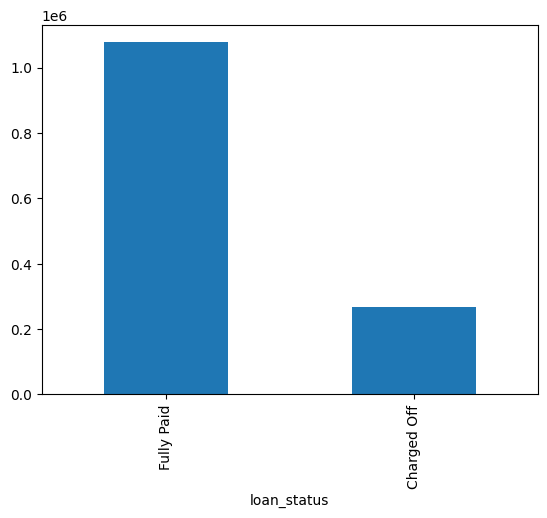

In [16]:
"""
Many of the features had to be omitted due to the nature they were obtained/created. Some examples are:
- zip_code, addr_state... (would constraint the system on location)
- grade, sub_grade... (a grade issued by the LC company)

Finally, the following features were picked to be used for predicting loan defaults:
"""
picked_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership',
                'annual_inc','purpose', 'issue_d', 'dti', 'pub_rec', 'last_pymnt_amnt', 'loan_status']

df = usable_df[picked_features]
df.info()

target_labels = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_labels)]
df.info()

# Lets see again what the ratio of classes is like.
df['loan_status'].value_counts().plot(kind='bar')
# The classes are imbalanced, we can combat this imbalance with class weights later!

# Info tells us there are still some null values.
print(df.isna().sum())

# Since there is a greater number of missing 'emp_length' values, and we can consider it a very indicative
# feature and we still will have enough data, we choose to omit all rows where the value is missing.

df = df.dropna(subset=['emp_length'])

# As for the 'dti', there is a smaller percentage missing - we will replace these with median.

In [11]:
"""
Data Exploration

Now that we have selected viable features and cleaned the dataset, it's time to explore our training data
"""
train_df, val_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.5)

train_df.describe(include='all')
train_df.info()

# Separate numerical and categorical columns
numerical_train_df = train_df.select_dtypes(include='float64')
categorical_train_df = train_df.select_dtypes(include='object')

numerical_train_df.info()
categorical_train_df.info()

[print(categorical_train_df[col].unique()) for col in categorical_train_df]

# In order to prevent feeding our model potentially hundreds of 'issue_d' categories,
# the dates can be generalized as years elapsed since unix epoch year.

def transform_issue_d(date):
    unix_timestamp_year = 1970
    year = int(date[-4:])
    return year - unix_timestamp_year

categorical_train_df['issue_d'] = categorical_train_df['issue_d'].apply(transform_issue_d)
[print(categorical_train_df[col].unique()) for col in categorical_train_df]
categorical_train_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1013439 entries, 1019794 to 391525
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   loan_amnt        1013439 non-null  float64
 1   term             1013439 non-null  object 
 2   int_rate         1013439 non-null  float64
 3   installment      1013439 non-null  float64
 4   emp_length       1013439 non-null  object 
 5   home_ownership   1013439 non-null  object 
 6   annual_inc       1013439 non-null  float64
 7   purpose          1013439 non-null  object 
 8   issue_d          1013439 non-null  object 
 9   dti              1013426 non-null  float64
 10  pub_rec          1013439 non-null  float64
 11  last_pymnt_amnt  1013439 non-null  float64
 12  loan_status      1013439 non-null  object 
dtypes: float64(7), object(6)
memory usage: 108.2+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1013439 entries, 1019794 to 391525
Data columns (total 7 columns):
 

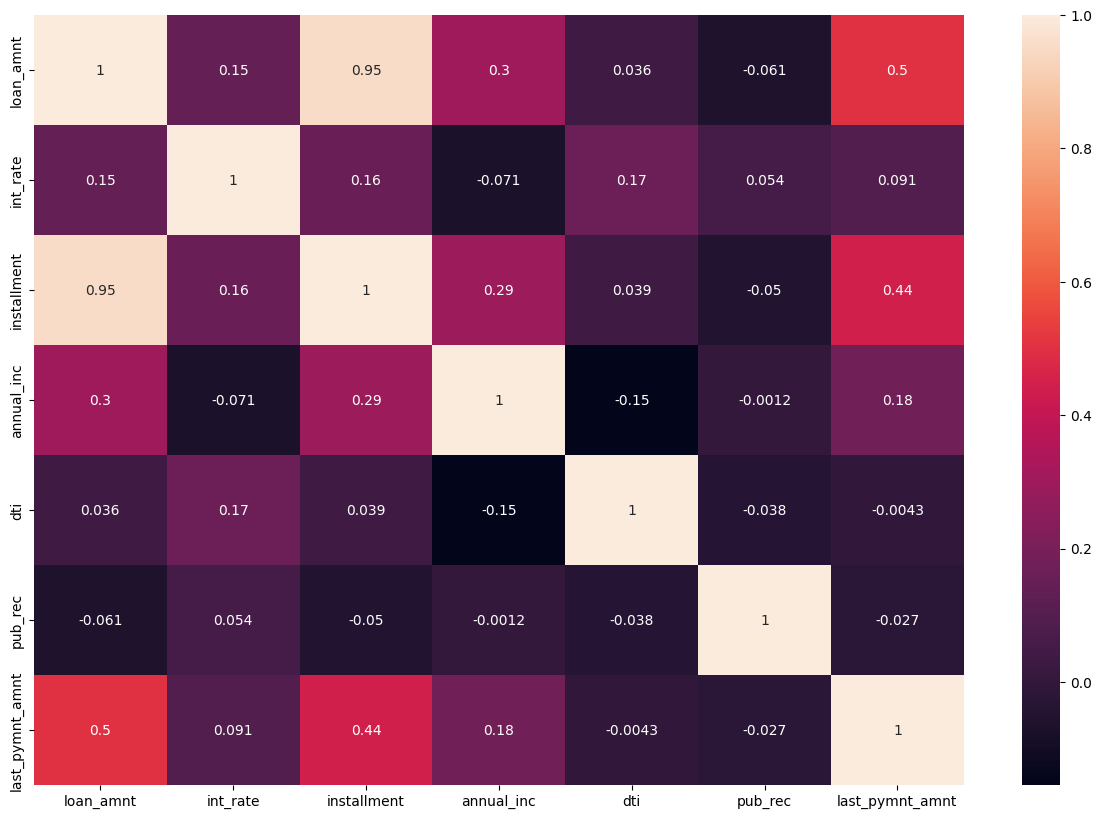

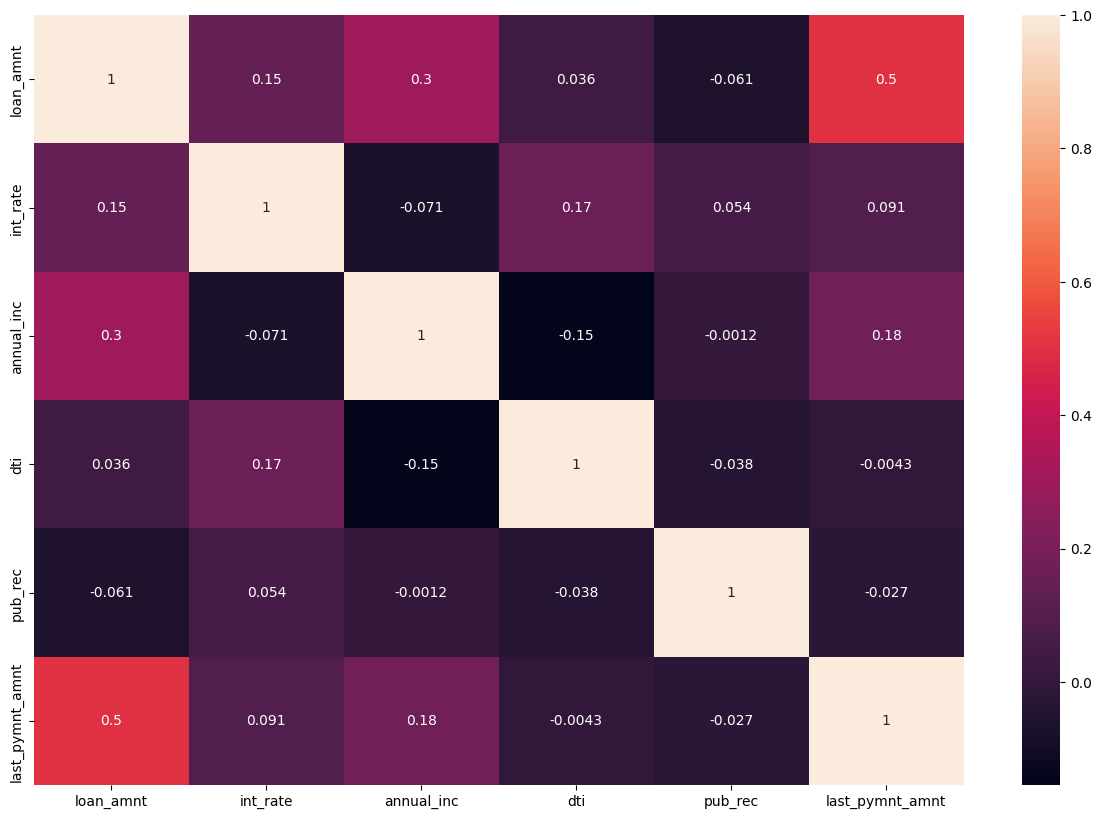

In [12]:
"""
Running correlation heatmap to see whether any numerical features are highly correlated, since we are
most likely going to use a regression model, where correlated features could cause trouble.
"""

plt.figure(figsize=(15,10))
sns.heatmap(numerical_train_df.corr(),annot=True)
plt.show()

# We choose to remove the 'installment' column as it is highly correlated with 'loan_amnt'. The
# installment values are still represented in the dataset via 'loan_amnt' and 'term'.

numerical_train_df = numerical_train_df.drop(columns=['installment'])

plt.figure(figsize=(15,10))
sns.heatmap(numerical_train_df.corr(),annot=True)
plt.show()

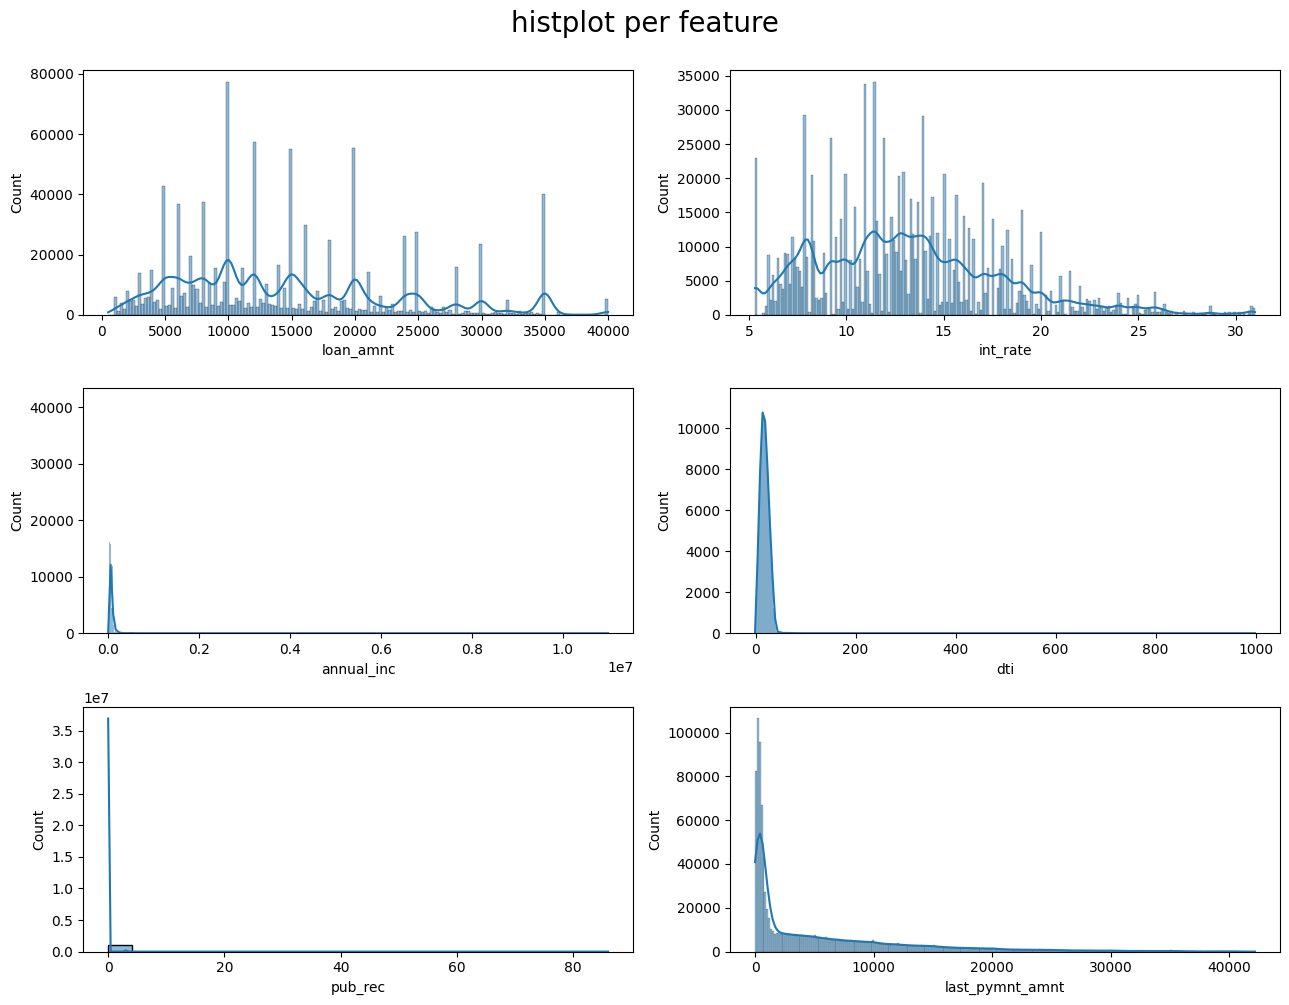

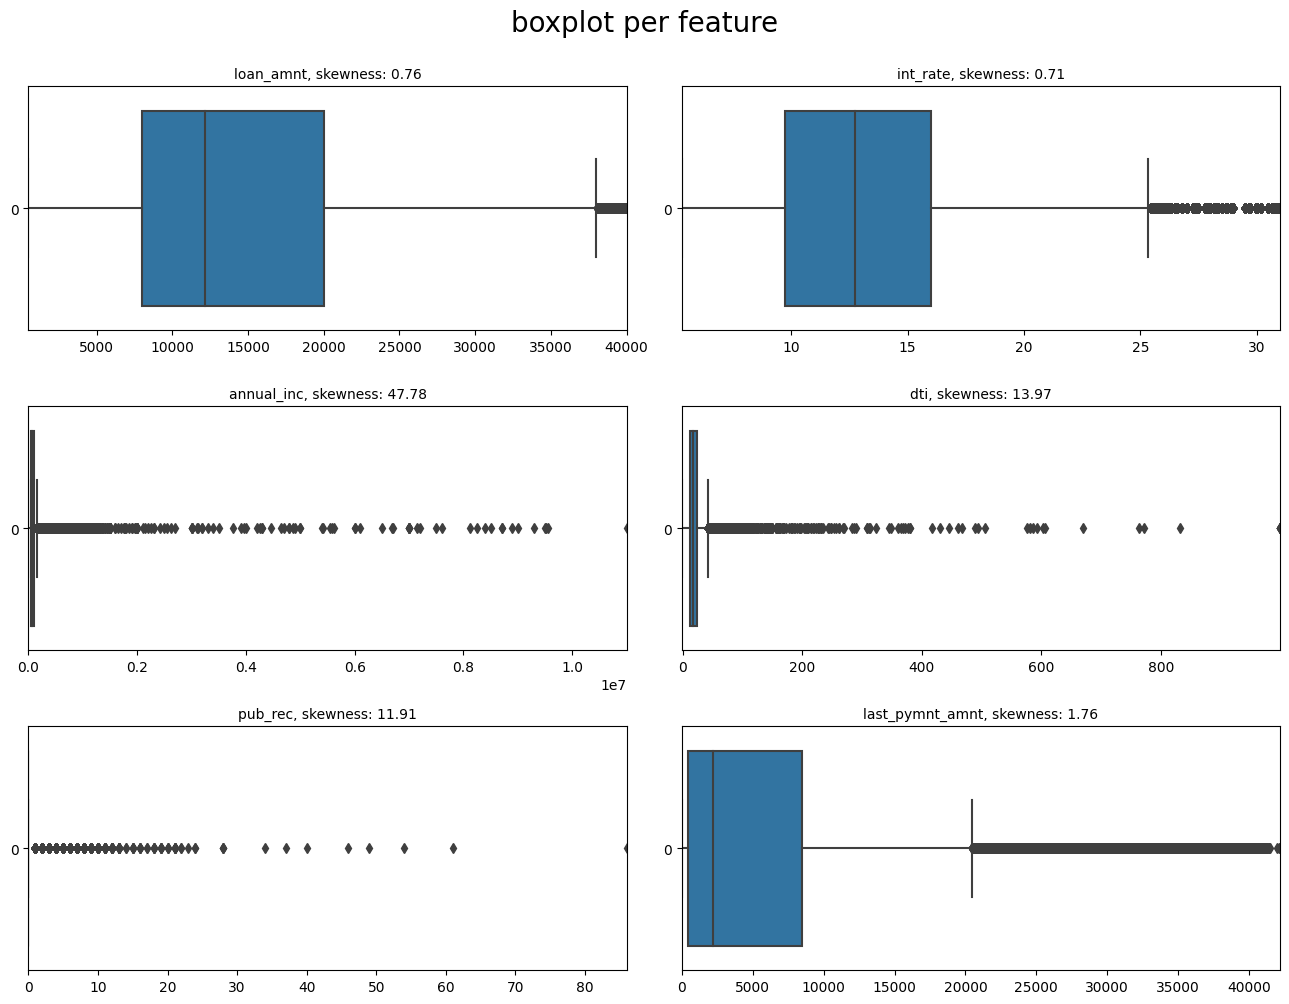

In [13]:
"""
Next, we visualize the histograms of numerical data to gain more insight about the distributions.
"""

def histplots(data,column):
    fig, ax = plt.subplots(3,2,figsize=(13,10))
    fig.suptitle('histplot per feature',y=1, size=20)
    ax=ax.flatten()
    for i, feature in enumerate(column):
        sns.histplot(data=data[feature],ax=ax[i], kde=True)

histplots(data=numerical_train_df,column=numerical_train_df.columns)
plt.tight_layout()

# It seems like there may be some outliers in some of the columns.
# Lets run introduce a boxplot to look for these.

def boxplots(data,column):
    data = data.reset_index(drop=True)
    fig, ax = plt.subplots(3,2,figsize=(13,10))
    fig.suptitle('boxplot per feature',y=1, size=20)
    ax=ax.flatten()
    for i, feature in enumerate(column):
        sns.boxplot(data=data[feature],ax=ax[i], orient='h')
        ax[i].set_title(feature+ ', skewness: '+str(round(data[feature].skew(axis = 0, skipna = True),2)),fontsize=10)
        ax[i].set_xlim([min(data[feature]), max(data[feature])])

boxplots(data=numerical_train_df,column=numerical_train_df.columns)
plt.tight_layout()

# Since we are going to use logistic regression, we do not care too much about the distributions
# and skewness, what we do need to be careful of though, are the extreme outliers.


Feature:  loan_amnt
Feature:  int_rate
Num of outliers:  7305
Some of the outliers:  (30.84, 30.94, 30.75, 28.34, 28.18, 30.84, 30.17, 29.69, 28.69, 28.34)
Mean:  29.78323887748118
Min:  27.79
Max:  30.99
Num of non-outliers:  1006134
Feature:  annual_inc
Num of outliers:  7721
Some of the outliers:  (357000.0, 315000.0, 293000.0, 400000.0, 453000.0, 1000000.0, 420000.0, 300000.0, 400000.0, 380000.0)
Mean:  473730.5944035747
Min:  293000.0
Max:  10999200.0
Num of non-outliers:  1005718
Feature:  dti
Num of outliers:  2189
Some of the outliers:  (59.32, 126.4, 48.72, 61.55, 58.01, 48.2, 79.38, 51.51, 58.74, 999.0)
Mean:  75.48066697121973
Min:  46.87
Max:  999.0
Num of non-outliers:  1011237
Feature:  pub_rec
Num of outliers:  1926
Some of the outliers:  (5.0, 7.0, 13.0, 5.0, 5.0, 7.0, 5.0, 5.0, 6.0, 10.0)
Mean:  6.547767393561786
Min:  5.0
Max:  86.0
Num of non-outliers:  1011513
Feature:  last_pymnt_amnt
Num of outliers:  21248
Some of the outliers:  (40214.76, 40060.27, 35009.42, 335

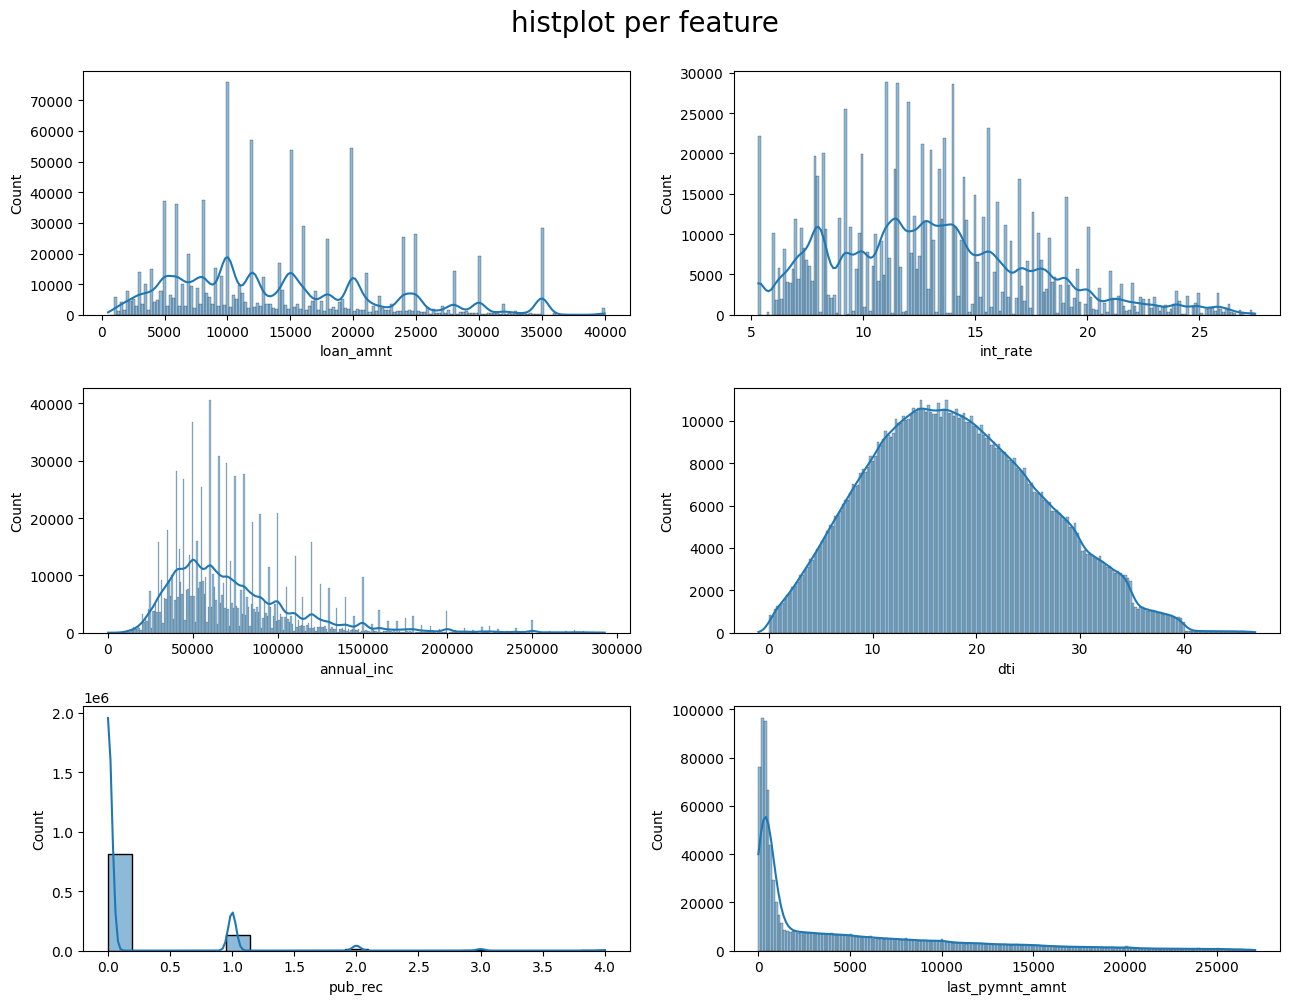

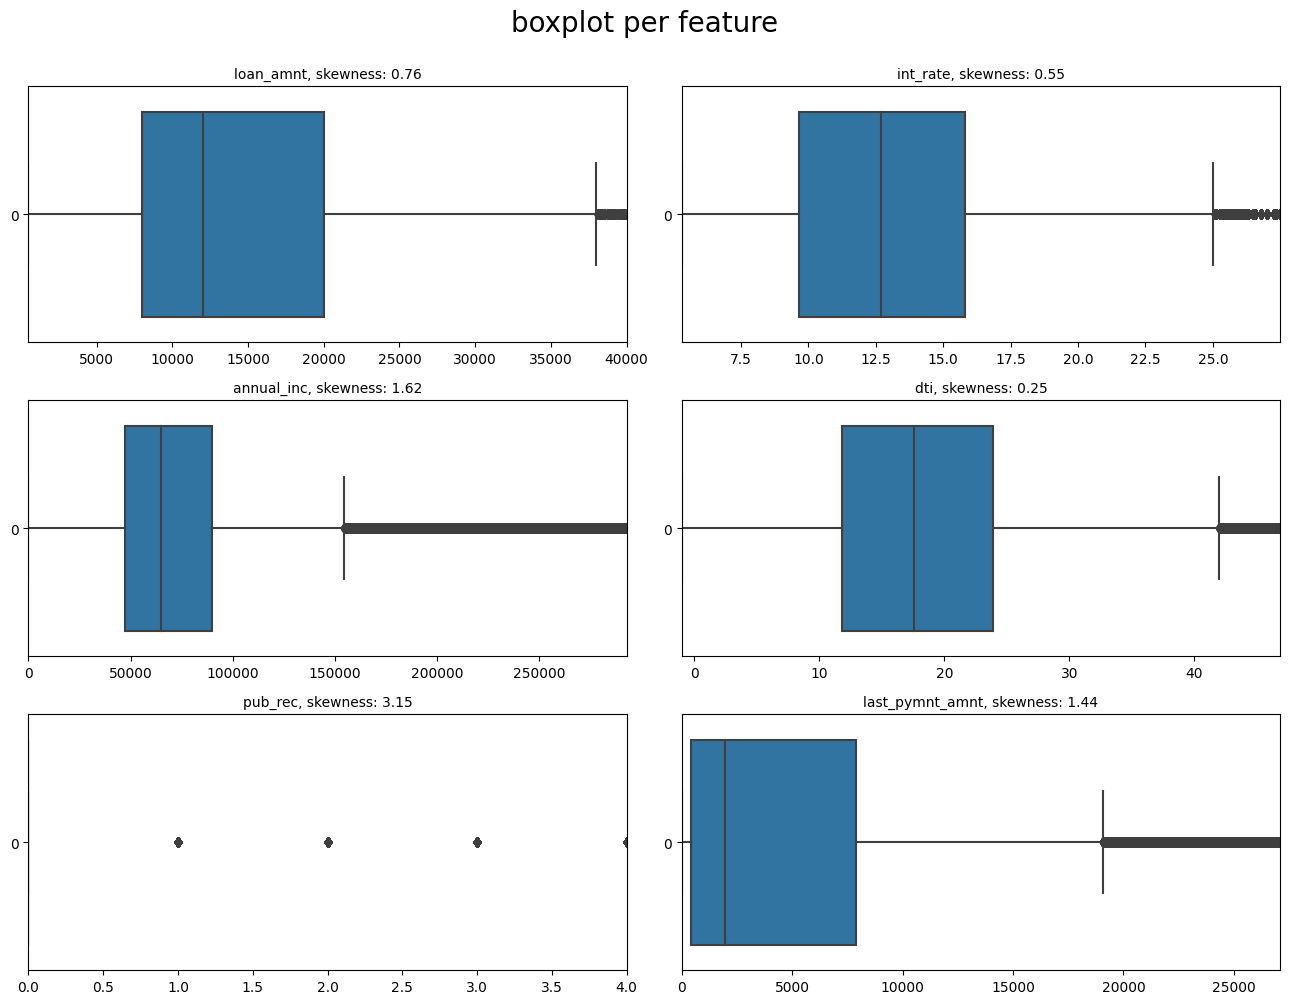

In [15]:
"""
There are multiple ways of detecting outliers, but since are dealing with 1D data, we shall employ
cutoffs via standard deviations.
"""

outliers_idx_unique = set(())

for col in numerical_train_df:
    print('Feature: ', col)
    mean, std = np.mean(numerical_train_df[col]), np.std(numerical_train_df[col])
    cut_off = std * 3
    if col == 'pub_rec':
      cut_off = std * 7
    lower, upper = mean - cut_off, mean + cut_off
    outliers = [[i, x[col]] for i, x in numerical_train_df.iterrows() if x[col] < lower or x[col] > upper]
    if outliers:
        outliers_idx, outliers = zip(*outliers)
        [outliers_idx_unique.add(r) for r in outliers_idx]
        print('Num of outliers: ', len(outliers))
        print('Some of the outliers: ', outliers[:10])
        print('Mean: ', np.mean(outliers))
        print('Min: ', np.min(outliers))
        print('Max: ', np.max(outliers))
        non_outliers = [x for x in numerical_train_df[col] if x >= lower and x <= upper]
        print('Num of non-outliers: ', len(non_outliers))

print('Num of unique outliers: ', len(outliers_idx_unique))
outliers_idx_unique = list(outliers_idx_unique)
print('Numerical len before: ', len(numerical_train_df))
numerical_train_df = numerical_train_df.drop(outliers_idx_unique)
print('Numerical len after: ', len(numerical_train_df))


# Now, the plots look much better.
histplots(data=numerical_train_df,column=numerical_train_df.columns)
plt.tight_layout()

boxplots(data=numerical_train_df,column=numerical_train_df.columns)
plt.tight_layout()

In [17]:
"""
Preprocessing:
Performing each step via a designated function in order to allow for easy unit/integration testing later.
"""
def remove_nan_cols(df, threshold):
    print(f"{dt.datetime.now().time()} removing nan cols...")
    nan_per_column = df.isna().sum()
    nan_percent_per_column = (nan_per_column / df.shape[0]) * 100
    non_nan_columns = df.columns[(nan_percent_per_column < threshold)].to_list()
    return df[non_nan_columns]

def pick_cols(df):
    print(f"{dt.datetime.now().time()} picking cols...")
    picked_features = ['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
                'annual_inc','purpose', 'issue_d', 'dti', 'pub_rec', 'last_pymnt_amnt', 'loan_status']
    return df[picked_features]

def filter_target_rows(df):
    print(f"{dt.datetime.now().time()} filtering target cols...")
    target_labels = ['Fully Paid', 'Charged Off']
    return df[df['loan_status'].isin(target_labels)]

def transform_cols(df):
    print(f"{dt.datetime.now().time()} transforming cols...")
    df['issue_d'] = df['issue_d'].apply(transform_issue_d)
    df['emp_length']= df['emp_length'].map({'< 1 year': 1,'2 years': 2,'3 years': 3,
                                        '4 years': 4, '5 years': 5,'6 years': 6,'7 years': 7,
                                        '8 years': 8,'9 years': 9, '10+ years': 10})
    df['term']= df['term'].map({' 36 months': 36, ' 60 months': 60})
    df['loan_status']= df['loan_status'].map({'Fully Paid':0, 'Charged Off':1})
    return df

def handle_missing_values(df):
    print(f"{dt.datetime.now().time()} handling missing values...")
    data = df.dropna(subset=['emp_length'])
    data.loc[:, ('dti')] = data['dti'].fillna(data['dti'].median())
    return data

# Use outlier_thresh if defined (from training data) otherwise calc and use outlier thresholds from training data.
def remove_numerical_outlier_rows(df, outlier_thresh):
    print(f"{dt.datetime.now().time()} removing outlier rows...")
    numerical_df = df.select_dtypes(include='float64')
    outliers_idx_unique = set(())
    for col in numerical_df:
        print(f"{dt.datetime.now().time()} checking col {col}")
        if col not in outlier_thresh:
            mean, std = np.mean(numerical_df[col]), np.std(numerical_df[col])
            cut_off = std * 3
            if col == 'pub_rec':
              cut_off = std * 7
            lower, upper = mean - cut_off, mean + cut_off
            outlier_thresh[col] = {'lower': lower, 'upper': upper}

        outliers = [[i, x[col]] for i, x in numerical_df.iterrows() if x[col] < outlier_thresh[col]['lower'] or x[col] > outlier_thresh[col]['upper']]
        if outliers:
            outliers_idx, outliers = zip(*outliers)
            [outliers_idx_unique.add(r) for r in outliers_idx]
            print('Num of outliers: ', len(outliers))
            print('Some of the outliers: ', outliers[:10])
            print('Mean: ', np.mean(outliers))
            print('Min: ', np.min(outliers))
            print('Max: ', np.max(outliers))
            non_outliers = [x for x in numerical_df[col] if x >= outlier_thresh[col]['lower'] and x <= outlier_thresh[col]['upper']]
            print('Num of non-outliers: ', len(non_outliers))

    outliers_idx_unique = list(outliers_idx_unique)
    return df.drop(outliers_idx_unique), outlier_thresh

def one_hot_encode_categorical(df):
    print(f"{dt.datetime.now().time()} one hot encoding...")
    categorical_df = df.select_dtypes(include='object')
    return pd.get_dummies(df, columns=categorical_df.columns, dtype=np.int8, drop_first=True)

# Use scaler if defined (from training data) otherwise calc and use scales from training data.
def normalize_numerical_rows(df, scaler):
    print(df.info())
    print(f"{dt.datetime.now().time()} normalizing...")
    if scaler:
        data = scaler.transform(df)
        return data, scaler

    scaler_init = MinMaxScaler()
    data = scaler_init.fit_transform(df)
    return data, scaler_init

def preprocess_loan_data(df, outlier_thresh):
    data = remove_nan_cols(df, 15)
    data = pick_cols(data)
    data = filter_target_rows(data)
    data = transform_cols(data)
    data = handle_missing_values(data)
    data, outlier_thresholds = remove_numerical_outlier_rows(data, outlier_thresh)
    data = one_hot_encode_categorical(data)
    print(f"{dt.datetime.now().time()} Finished preprocessing!\n\n")
    return data, outlier_thresholds


In [18]:
"""
Creation and separate processing of train, validation and test split with train normalization
scales and outlier thresholds to avoid data leakage! 

These normalization scales and outlier thresholds are to be used in the web app while processing
new data from the users!
"""

train_df, val_df = train_test_split(accepted_df, test_size=0.2)
val_df, test_df = train_test_split(val_df, test_size=0.5)

print(train_df.info())
print(val_df.info())
print(test_df.info())

# Calculate o_thresh first, then use for the validation and test splits to
# simmulate real world/production scenario.
train_df, o_thresh = preprocess_loan_data(train_df, {})
val_df = preprocess_loan_data(val_df, o_thresh)[0]
test_df = preprocess_loan_data(test_df, o_thresh)[0]

print(type(train_df))
print(type(val_df))
print(type(test_df))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Index: 1808560 entries, 1896809 to 2193498
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.0+ GB
None
<class 'pandas.core.frame.DataFrame'>
Index: 226070 entries, 1581382 to 99512
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 262.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 226071 entries, 524340 to 494555
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 262.2+ MB
None
11:30:19.556897 removing nan cols...
11:30:25.403487 picking cols...
11:30:25.913667 filtering target cols...
11:30:26.246609 transforming cols...
11:30:27.048551 handling missing values...
11:30:27.348243 removing outlier rows...
11:30:27.449159 checking col loan_amnt
11:31:14.642414 checking col int_rate
Num of outliers:  6849
So

In [19]:
"""
Prepare data for training.
"""
X_train, y_train = train_df.drop('loan_status', axis=1), train_df['loan_status']
X_val, y_val = val_df.drop('loan_status', axis=1), val_df['loan_status']
X_test, y_test = test_df.drop('loan_status', axis=1), test_df['loan_status']

# Calculate n_thresh first, then use for the validation and test splits to
# simmulate real world/production scenario.
X_train, n_thresh = normalize_numerical_rows(X_train, {})
X_val = normalize_numerical_rows(X_val, n_thresh)[0]
X_test = normalize_numerical_rows(X_test, n_thresh)[0]

X_train, y_train = np.array(X_train).astype(np.float32), np.array(y_train).astype(np.float32)
X_val, y_val = np.array(X_val).astype(np.float32), np.array(y_val).astype(np.float32)
X_test, y_test = np.array(X_test).astype(np.float32), np.array(y_test).astype(np.float32)

<class 'pandas.core.frame.DataFrame'>
Index: 907278 entries, 1186792 to 2193498
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   907278 non-null  float64
 1   term                        907278 non-null  int64  
 2   int_rate                    907278 non-null  float64
 3   emp_length                  907278 non-null  float64
 4   annual_inc                  907278 non-null  float64
 5   issue_d                     907278 non-null  int64  
 6   dti                         907278 non-null  float64
 7   pub_rec                     907278 non-null  float64
 8   last_pymnt_amnt             907278 non-null  float64
 9   home_ownership_MORTGAGE     907278 non-null  int8   
 10  home_ownership_NONE         907278 non-null  int8   
 11  home_ownership_OTHER        907278 non-null  int8   
 12  home_ownership_OWN          907278 non-null  int8   
 13  home_ownersh

In [20]:
"""
Other techniques we could use are, for example, oversampling or undersampling of given classes.
"""

unique, counts = np.unique(y_train, return_counts=True)
print('Classes, their counts:', unique, counts)
# Calculate class weight to mitigate unbalanced target classes.
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
print('Class weights: ', class_weights)



Classes, their counts: [0. 1.] [729192 178086]
Class weights:  {0.0: 0.622111871770398, 1.0: 2.5473029884437857}


In [21]:
# Used for experimentation and search for suitable hyperparameters.
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

# Used to build the final model using the input hyperparameters.
def build_best_model(num_layers, units, learning_rate):
    model = keras.Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(layers.Dense(units[i], input_dim=X_train.shape[1], activation='relu'))
        model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [24]:
"""
If we were to have more time, we could perform a more extensive search for suitable hyperparameters.
"""
tuner = kt.RandomSearch(
    build_model,
    seed=42,
    objective='val_accuracy',
    max_trials=3)

# Early stopping to save time.
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train, epochs=4, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps['num_layers'], best_hps['units_0'], best_hps['units_1'], best_hps['learning_rate'])

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
4 160 32 0.01


In [25]:
# Unused best_hps as manual configuration was better than a few initial best_hps searches.
# model = build_best_model(best_hps['num_layers'], [best_hps['units_' + str(i)] for i in range(best_hps['num_layers'])], best_hps['learning_rate'])
model = build_best_model(3, [128, 128, 128,], 0.001)
history = model.fit(X_train, y_train, epochs=6, class_weight=class_weights, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/6
28353/28353 [==============================] - 53s 2ms/step - loss: 0.3279 - accuracy: 0.8096 - val_loss: 0.3431 - val_accuracy: 0.8141
Epoch 2/6
28353/28353 [==============================] - 52s 2ms/step - loss: 0.3141 - accuracy: 0.8141 - val_loss: 0.3262 - val_accuracy: 0.8258
Epoch 3/6
28353/28353 [==============================] - 51s 2ms/step - loss: 0.3124 - accuracy: 0.8157 - val_loss: 0.3368 - val_accuracy: 0.8113
Epoch 4/6
28353/28353 [==============================] - 51s 2ms/step - loss: 0.3120 - accuracy: 0.8158 - val_loss: 0.3311 - val_accuracy: 0.8210
Epoch 5/6
28353/28353 [==============================] - 52s 2ms/step - loss: 0.3110 - accuracy: 0.8162 - val_loss: 0.3279 - val_accuracy: 0.8203
Epoch 6/6
28353/28353 [==============================] - 51s 2ms/step - loss: 0.3095 - accuracy: 0.8161 - val_loss: 0.3434 - val_accuracy: 0.8149


In [26]:
# Getting prediction scores.
y_test_pred = model.predict(X_test)
# Getting predictions labels based on a simple threshold. This threshold could be chosen more appropriately.
y_test_pred_thresh = (y_test_pred > 0.5)


3542/3542 [==============================] - 3s 893us/step


In [27]:
# Evauation results of model on test set.
print("Confusion Matrix: \n",confusion_matrix(y_test,y_test_pred_thresh))
print('\n')
print("Accuracy Score: \n",accuracy_score(y_test,y_test_pred_thresh))
print('\n')
print("Classification Report: \n",classification_report(y_test,y_test_pred_thresh))

Confusion Matrix: 
 [[71490 19380]
 [ 1321 21124]]


Accuracy Score: 
 0.8173145655914927


Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.79      0.87     90870
         1.0       0.52      0.94      0.67     22445

    accuracy                           0.82    113315
   macro avg       0.75      0.86      0.77    113315
weighted avg       0.89      0.82      0.83    113315



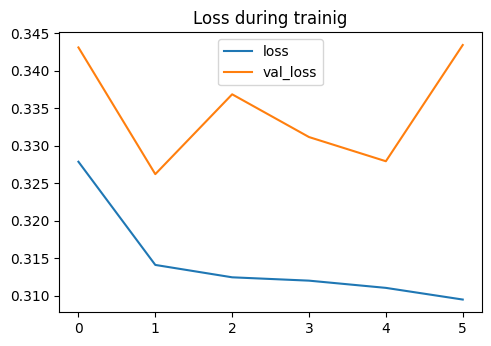

In [28]:
"""
Since we only trained for 6 epochs, the graph is not very indicative of properly trained model.
"""
plt.figure(figsize=(12, 8))

# Plot loss during training.
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss during trainig')
plt.legend()

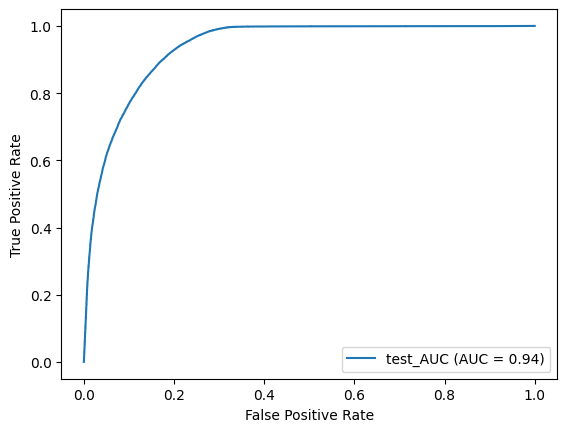

In [29]:
"""
The AUC seems to have a initial good yield. Given more time, we could improve this further.
"""
# Plot ROC curve.
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='test_AUC')
display.plot()
plt.show()

In [160]:
# Save .pb model to be deployed to Vertex AI as a PredictionService.
model.save('my_model')

2023-05-28 03:03:17.821599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-28 03:03:17.842406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-28 03:03:17.865496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-28 03:03

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [162]:
# Predict a single test entry to compare with deployed model, and request made via web app.
pred_X_test, pred_y_test = X_test[0], y_test[0]
print(pred_X_test)
print(pred_y_test)
print(y_test_pred[0])

[0.24050634 0.         0.05320108 0.5555556  0.29310346 0.72727275
 0.2940439  0.25       0.06663288 0.         0.         0.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
0.0
[0.02206531]
